In [16]:
#packages

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from scipy.optimize import curve_fit
import pandas as pd


#centeroid finder
def centeroid(pic):
    x_len, y_len = pic.shape
    c_cord = np.array([0,0])
    weight = np.sum(pic)
    for i in range(x_len):
        for j in range(y_len):
            c_cord[0] += pic[i][j]*i
            c_cord[1] += pic[i][j]*j       
    return c_cord[0]//weight , c_cord[1]//weight

#crop_around
def crop_around(stars_img, star_x, star_y):
    return stars_img[star_y-50: star_y+50].T[star_x-50: star_x+50].T

#bad pixel removal
def bad_pix_rem(star_img):
    for i in range(1,99):
        for j in range(1,99):
            nhood=np.array([star_img[i-1][j],star_img[i-1][j-1],star_img[i-1][j+1],star_img[i][j-1],star_img[i][j+1],
                            star_img[i+1][j],star_img[i+1][j-1],star_img[i+1][j+1]])
            nhood_med=np.median(nhood)
            if star_img[i][j]>200 + nhood_med:
                star_img[i][j]=nhood_med
    return star_img

In [17]:
#initializing_data 

starsss=pd.read_csv("stars.csv")
loc_x = np.array(starsss["x0"].tolist())
loc_y = np.array(starsss["y0"].tolist())

img = fits.open('light-r_20C-2023_10_10-exp00.03.00.000-1x1_High_3.fit')
img_data = img[0].data
img_len_x, img_len_y = img_data.shape
asec_per_pix=0.047
sigma_hist=np.array([])
delta_sigma_hist=np.array([])

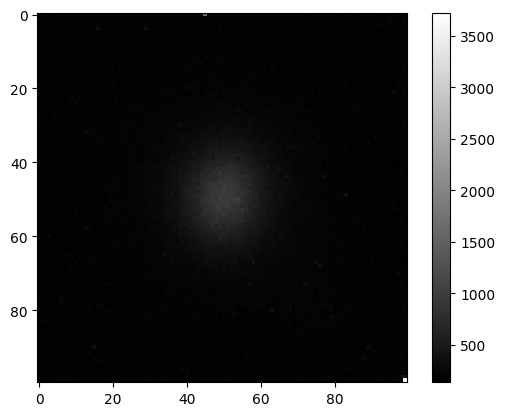

C:\Users\ExoGame\AppData\Local\Temp\ipykernel_1748\1739786143.py:19: RuntimeWarning: overflow encountered in scalar multiply
  c_cord[1] += pic[i][j]*j
C:\Users\ExoGame\AppData\Local\Temp\ipykernel_1748\1739786143.py:18: RuntimeWarning: overflow encountered in scalar multiply
  c_cord[0] += pic[i][j]*i


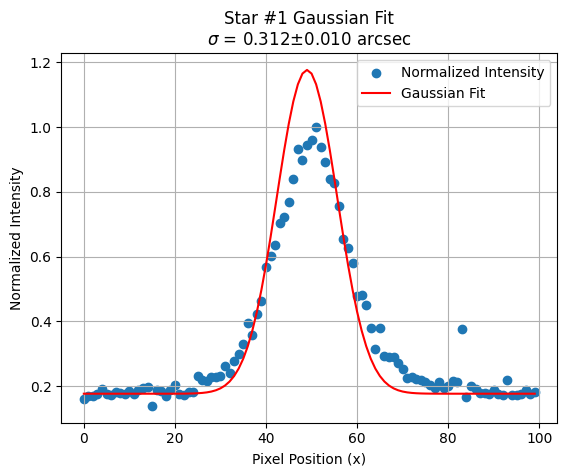

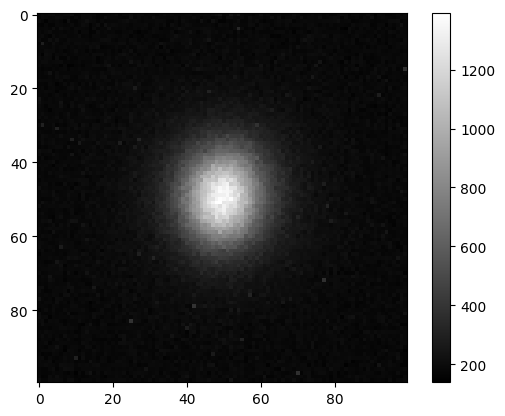

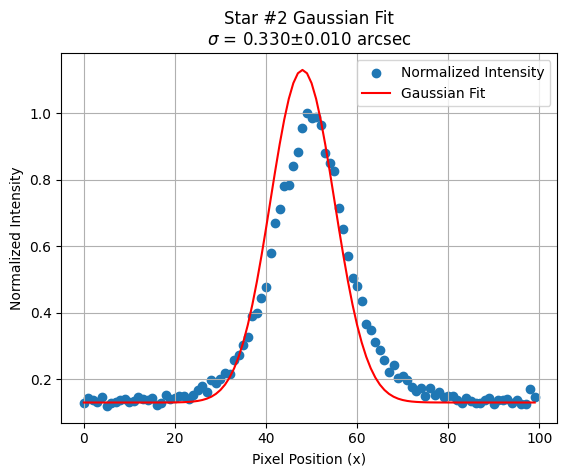

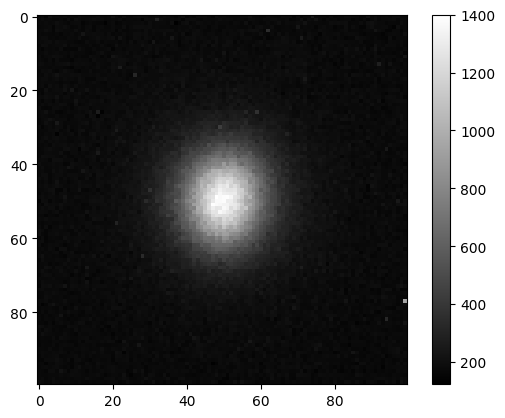

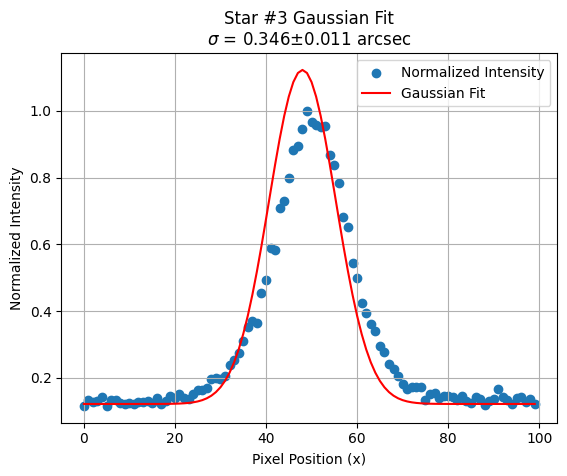

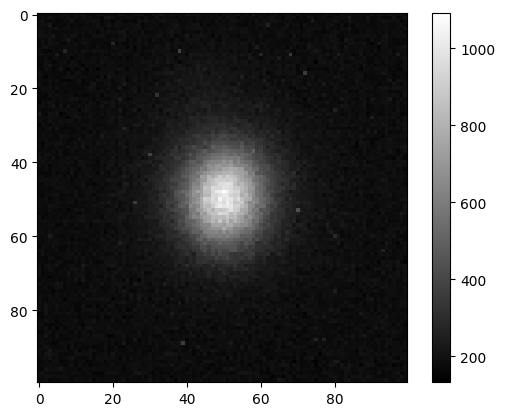

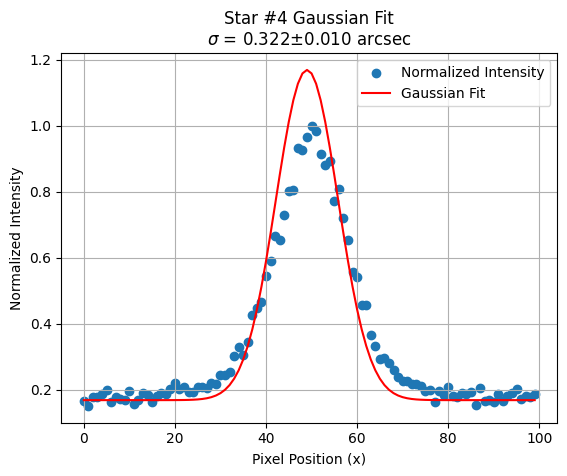

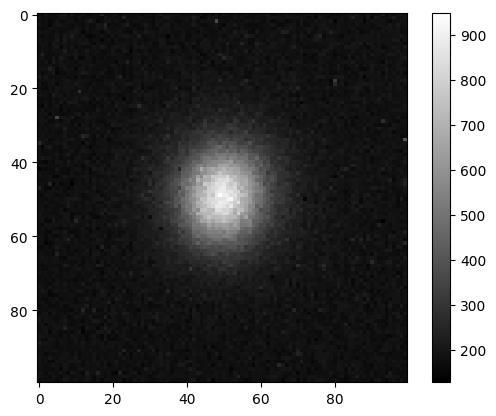

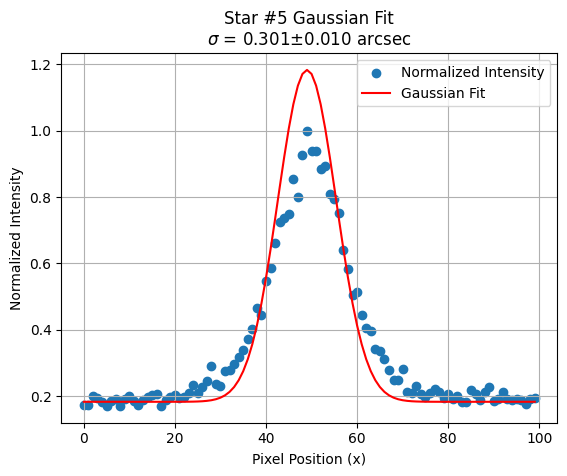

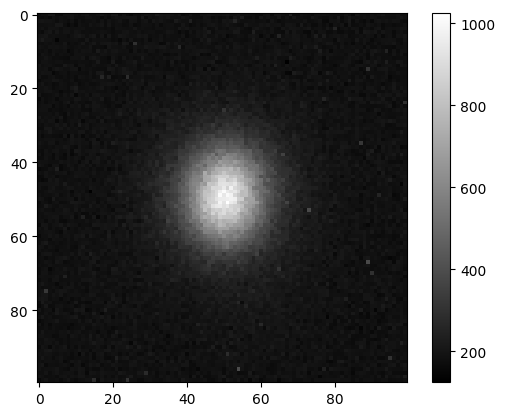

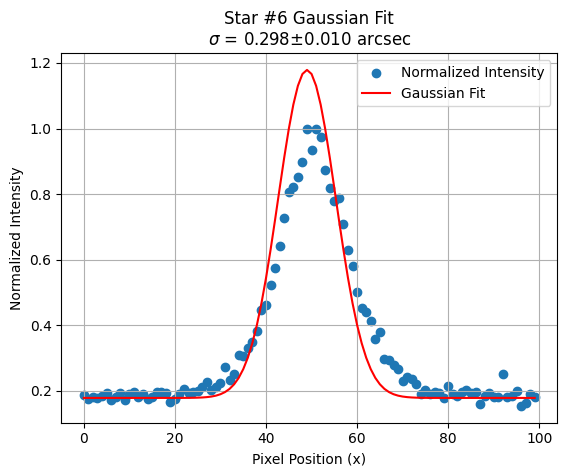

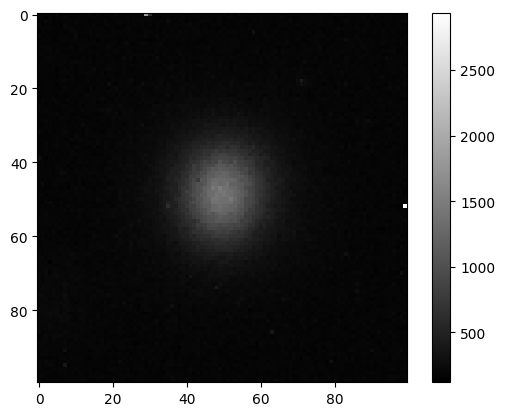

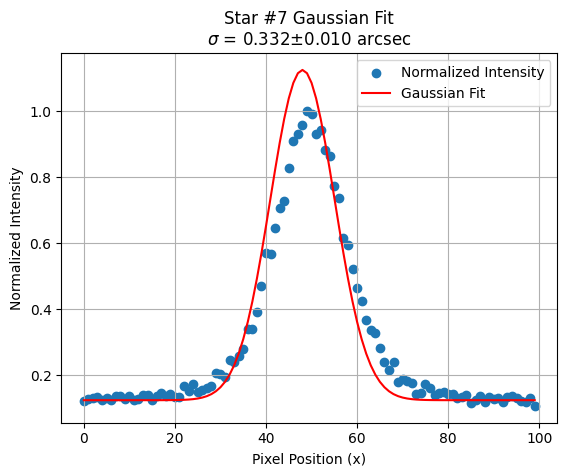

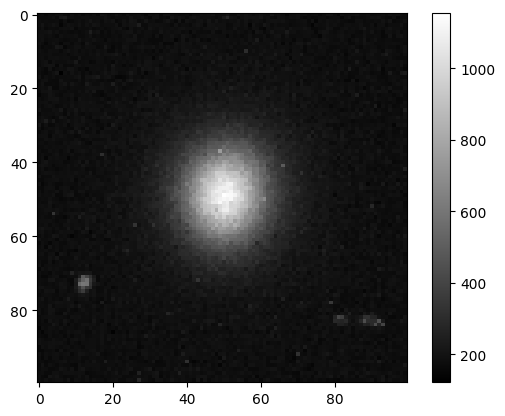

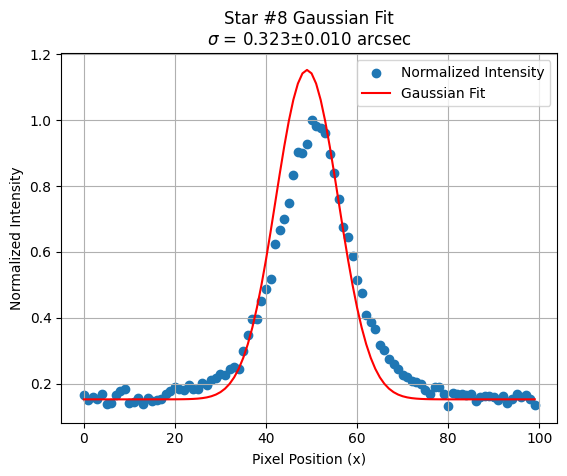

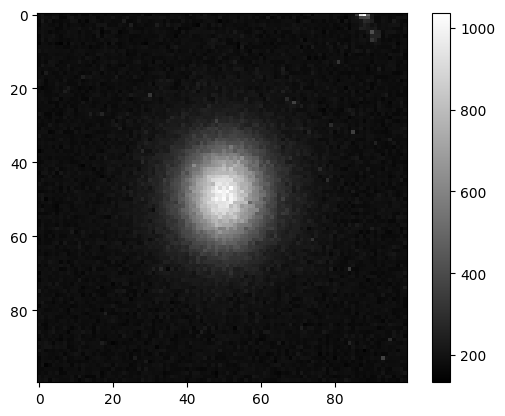

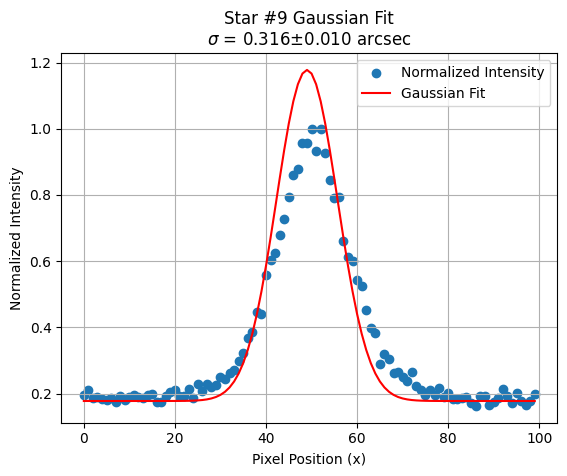

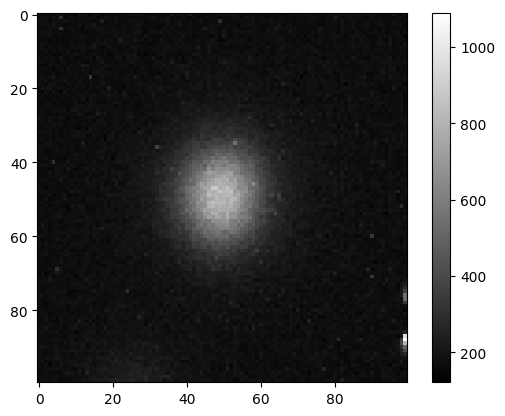

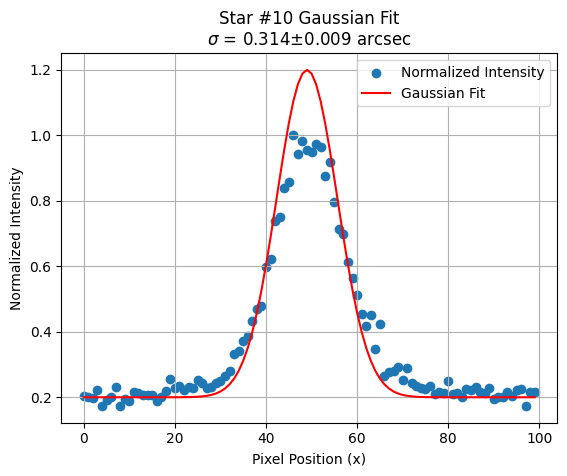

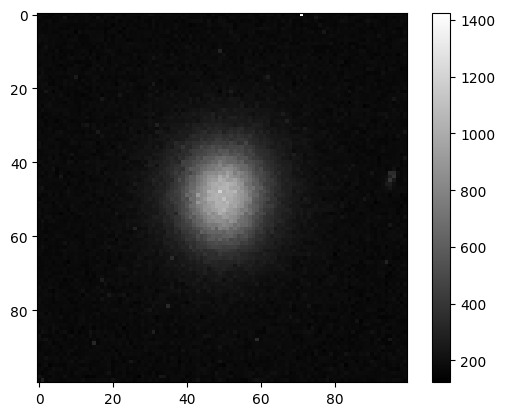

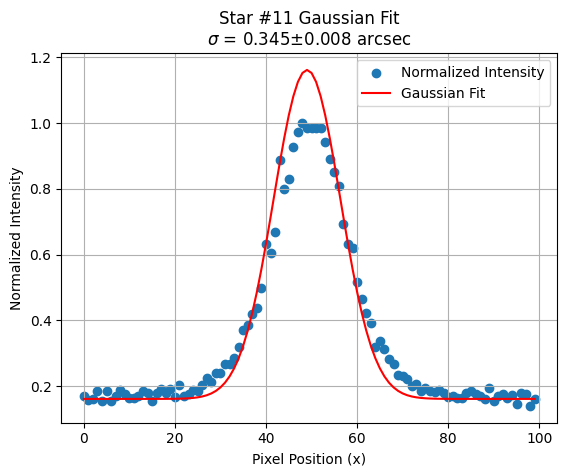

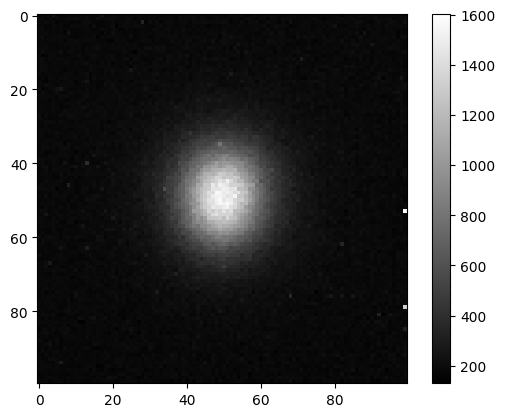

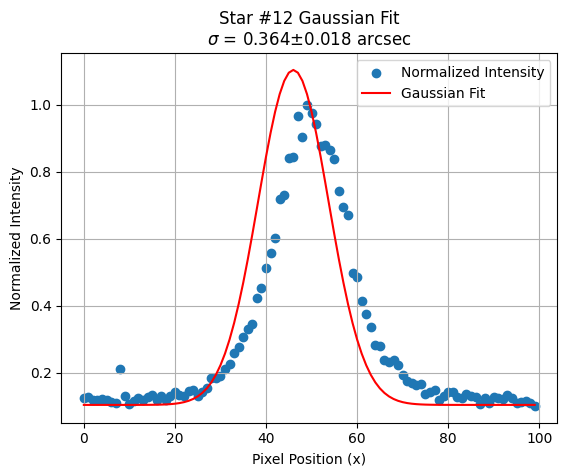

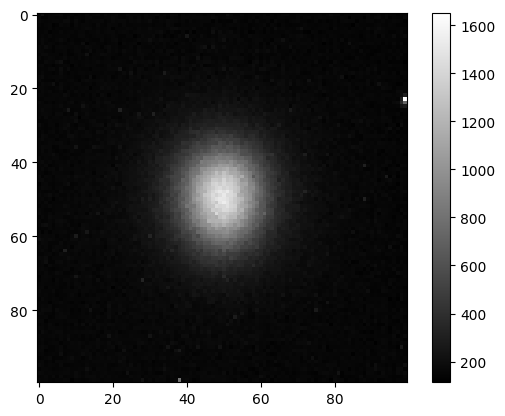

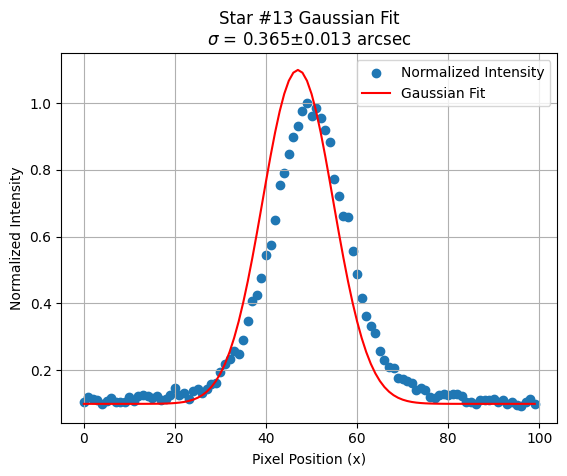

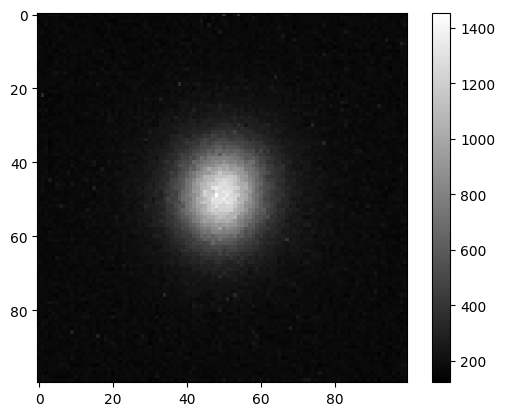

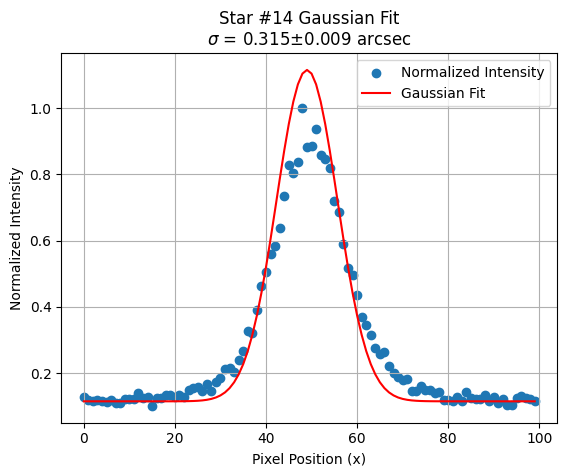

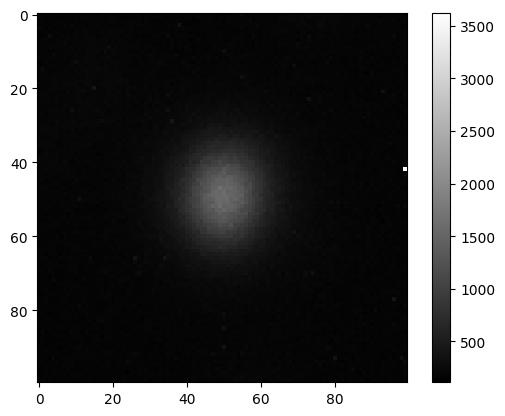

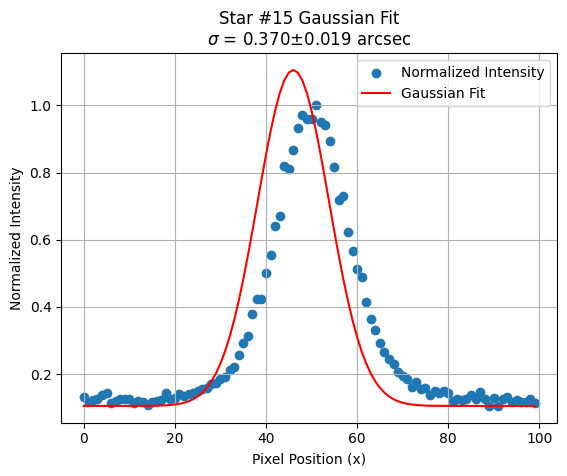

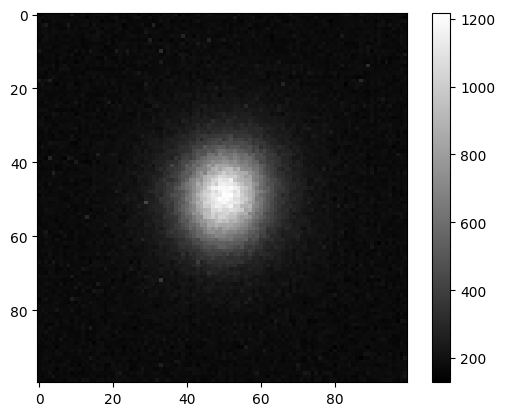

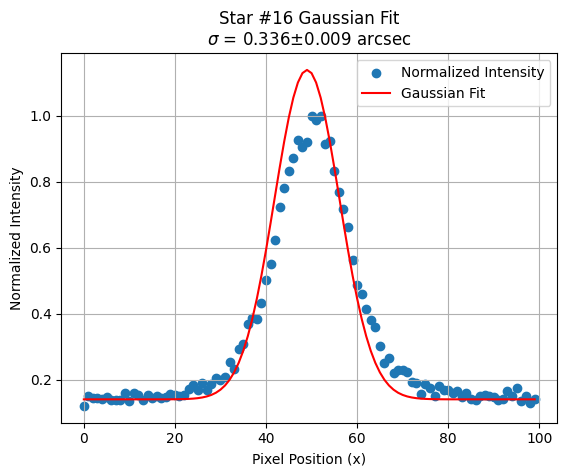

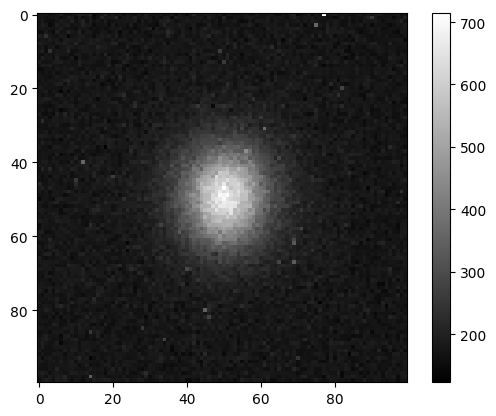

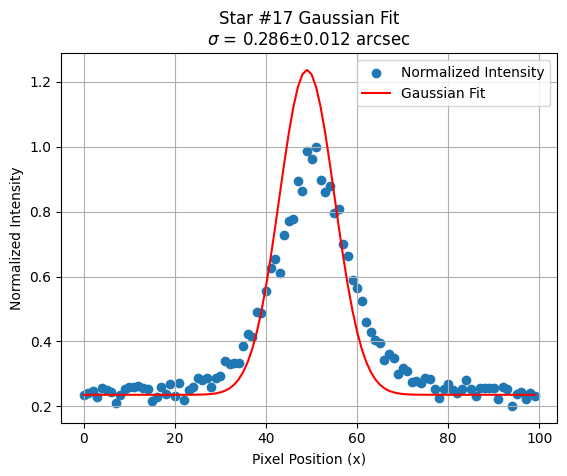

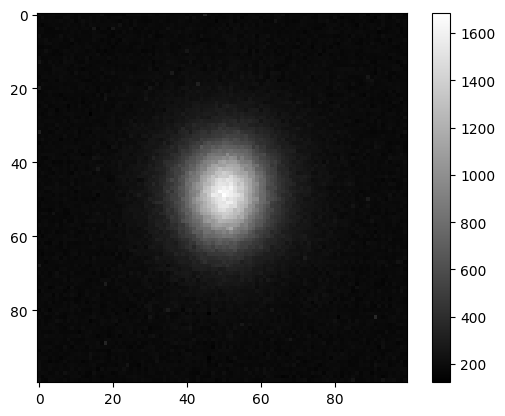

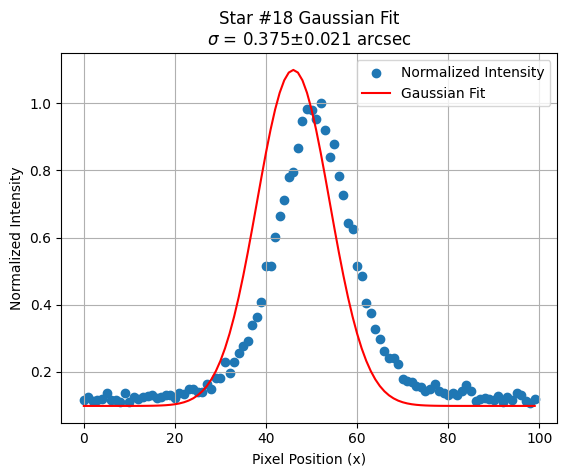

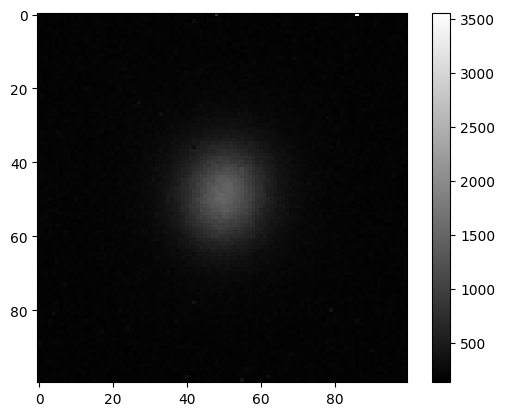

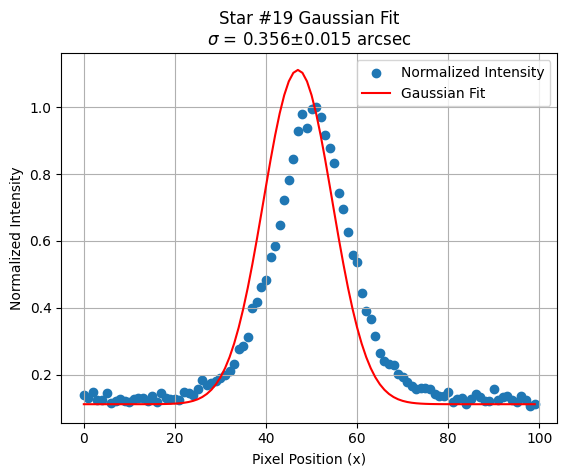

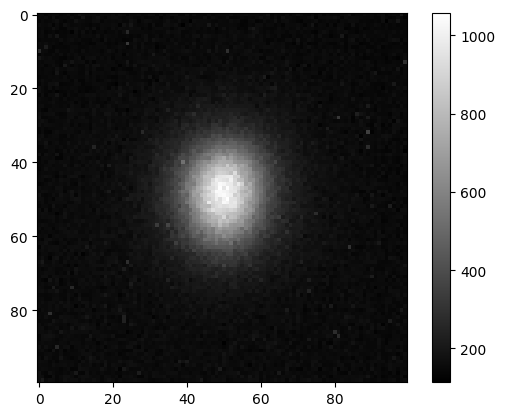

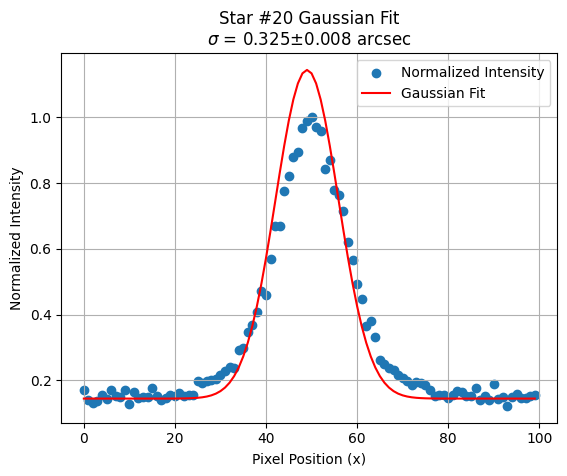

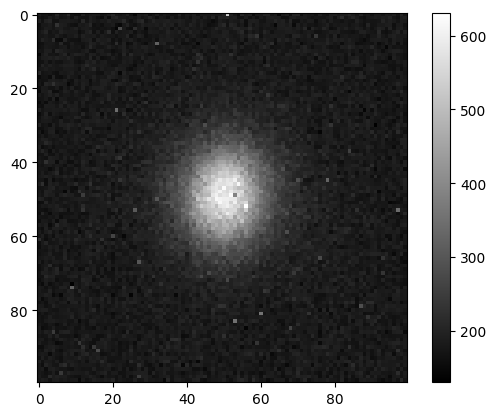

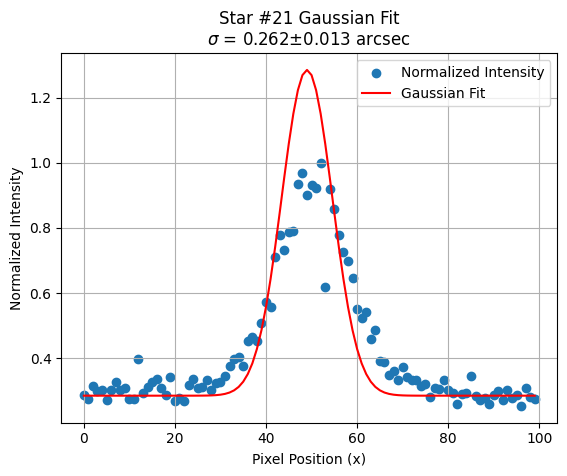

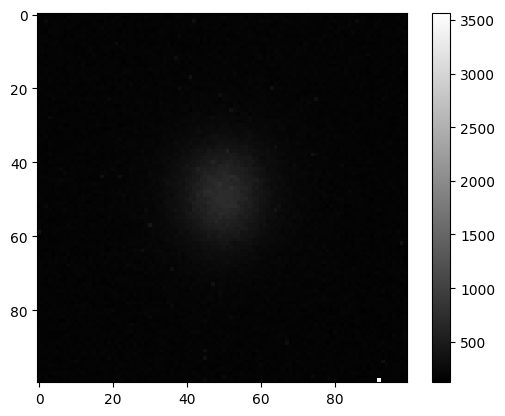

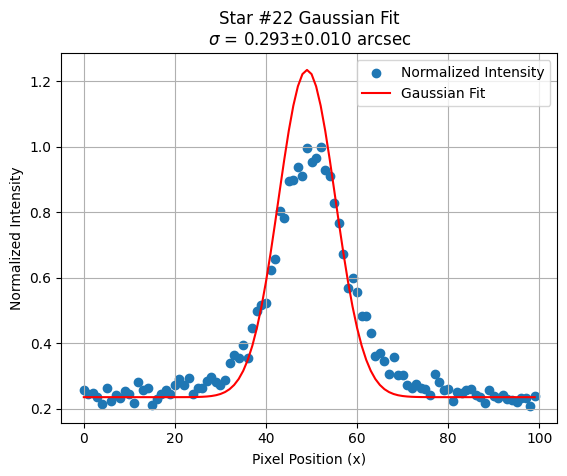

In [18]:
for i in range(len(loc_x)):
    star_0_img=bad_pix_rem(crop_around(img_data, int(loc_x[i]), img_len_y - int(loc_y[i])))

    #corrected_pic_print
    plt.imshow(star_0_img, cmap='gray')
    plt.colorbar()
    plt.show()

    #curve_fit_setup

    x_data=np.arange(0,100)
    intensity=star_0_img[0:100][int(centeroid(star_0_img)[0])]
    max_intensity=intensity.max()
    intensity=intensity/max_intensity

    def gauss(x,a,b):
        return np.exp(-a * (x-centeroid(star_0_img)[0])**2)+b

    popt, pcov=curve_fit(gauss,x_data,intensity)
    delta_a=(pcov[0][0])**(1/2)
    sigma_pix=(popt[0]**(-1)/2)**(0.5)
    delta_sigma_pix=(sigma_pix**3)*delta_a
    sigma=sigma_pix*asec_per_pix
    delta_sigma=delta_sigma_pix*asec_per_pix
    sigma_hist=np.append(sigma_hist,sigma)
    delta_sigma_hist=np.append(delta_sigma_hist,delta_sigma)

    # intensity profile for one star
    plt.figure()
    plt.scatter(x_data, intensity, label="Normalized Intensity")
    plt.plot(x_data, gauss(x_data, *popt), color='red', label="Gaussian Fit")
    plt.xlabel("Pixel Position (x)")
    plt.ylabel("Normalized Intensity")
    plt.title(f"Star #{i+1} Gaussian Fit\n$\sigma$ = {sigma:.3f}±{delta_sigma:.3f} arcsec")
    plt.legend()
    plt.grid(True)
    plt.show()


Mean Gaussian Width (σ): 0.3267 arcsec
Standard Deviation: 0.0285 arcsec
Mean Uncertainty (Δσ): 0.0118 arcsec


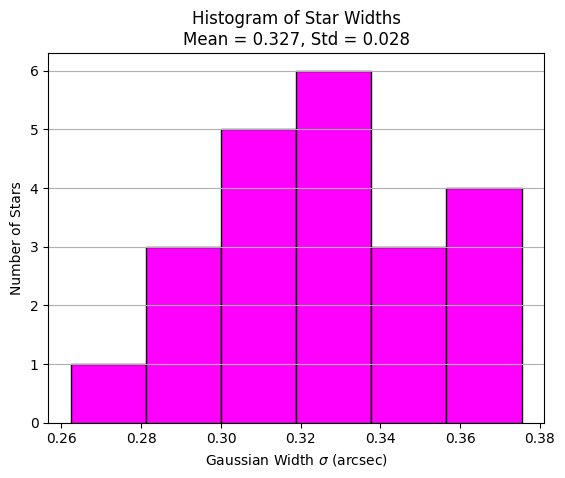

In [19]:
# plt.hist(sigma_hist)
# plt.show()

# print("Mean width (arcsec):", np.mean(sigma_hist))
# print("Standard deviation of widths (arcsec):", np.std(sigma_hist))
# print("Mean uncertainty (arcsec):", np.mean(delta_sigma_hist))

# Compute statistics
mean_sigma = np.mean(sigma_hist)
std_sigma = np.std(sigma_hist)
mean_delta_sigma = np.mean(delta_sigma_hist)

# Print stats
print("Mean Gaussian Width (σ): {:.4f} arcsec".format(mean_sigma))
print("Standard Deviation: {:.4f} arcsec".format(std_sigma))
print("Mean Uncertainty (Δσ): {:.4f} arcsec".format(mean_delta_sigma))

# Plot histogram
plt.figure()
plt.hist(sigma_hist, bins='auto', color='magenta', edgecolor='black')
plt.xlabel("Gaussian Width $\sigma$ (arcsec)")
plt.ylabel("Number of Stars")
plt.title(f"Histogram of Star Widths\nMean = {mean_sigma:.3f}, Std = {std_sigma:.3f}")
plt.grid(axis='y')
plt.show()
